In [30]:
# 📦 Base Python
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2

# 📊 Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# 🔤 Prétraitement
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 🧠 Deep Learning - Keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.applications import ResNet50 #, EfficientNetB0


from ClassImage import ImagePreprocessor, ImageGeneratorBuilder, CustomClassifier


In [31]:
# Charger X_train et Y_train avec l’index renommé
X_train = pd.read_csv("X_train_update.csv").rename(columns={"Unnamed: 0": "id"})
Y_train = pd.read_csv("Y_train_CVw08PX.csv").rename(columns={"Unnamed: 0": "id"})

# Fusionner pour obtenir productid + prdtypecode
df_labels = X_train[["id", "productid"]].merge(Y_train, on="id", how="inner")

print(df_labels.head())

   id   productid  prdtypecode
0   0  3804725264           10
1   1   436067568         2280
2   2   201115110           50
3   3    50418756         1280
4   4   278535884         2705


In [32]:
# Dossier image 
IMAGE_DIR = "images/image_train"

# Parser les noms de fichiers
def parse_filename(filename):
    try:
        parts = filename.replace(".jpg", "").split("_")
        imageid = int(parts[1])
        productid = int(parts[3])
        return imageid, productid
    except:
        return None, None

# Créer un DataFrame avec tous les fichiers valides
file_data = []
for fname in os.listdir(IMAGE_DIR):
    if fname.endswith(".jpg"):
        imageid, productid = parse_filename(fname)
        if imageid and productid:
            file_data.append({
                "imageid": imageid,
                "productid": productid,
                "image_path": os.path.join(IMAGE_DIR, fname)
            })

df_images = pd.DataFrame(file_data)

# Fusion entre df_images et df_labels via productid
df = df_images.merge(df_labels[["productid", "prdtypecode"]], on="productid", how="inner")

print(df.head)


<bound method NDFrame.head of           imageid   productid  \
0      1174594490  2940640728   
1      1172460449   185143847   
2      1313553701  4199252811   
3      1008107210   435919430   
4      1190251689  2738644573   
...           ...         ...   
84911  1241012390  3752128882   
84912  1275804073  4004617931   
84913  1299295339  4141676126   
84914  1169544310  2379335621   
84915  1282008871  4050754276   

                                              image_path  prdtypecode  
0      images/image_train/image_1174594490_product_29...         2583  
1      images/image_train/image_1172460449_product_18...         1560  
2      images/image_train/image_1313553701_product_41...           40  
3      images/image_train/image_1008107210_product_43...         2280  
4      images/image_train/image_1190251689_product_27...         2583  
...                                                  ...          ...  
84911  images/image_train/image_1241012390_product_37...         2583

## Analyse Exploratoire : 

**Distribution de la cible :**

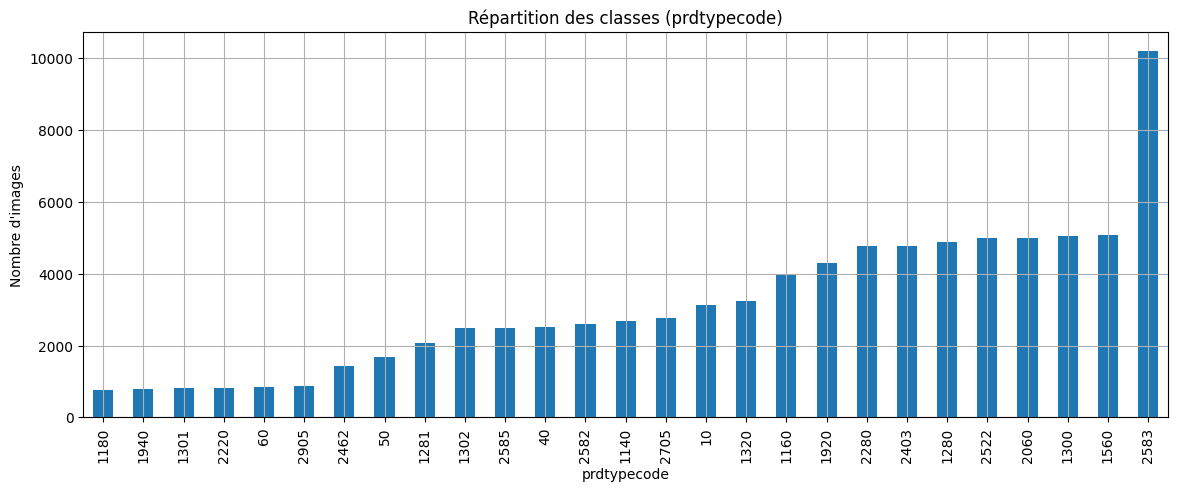

In [33]:
plt.figure(figsize=(14,5))
df["prdtypecode"].value_counts().sort_values(ascending=True).plot(kind="bar")
plt.title("Répartition des classes (prdtypecode)")
plt.xlabel("prdtypecode")
plt.ylabel("Nombre d'images")
plt.grid(True)
plt.show()


In [34]:
df_sample = df.groupby("prdtypecode").apply(lambda x: x.sample(n=min(len(x), 300), random_state=42)).reset_index(drop=True)

# Taille de l'échantillon :
df_sample.count()

/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_41594/1270548984.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby("prdtypecode").apply(lambda x: x.sample(n=min(len(x), 300), random_state=42)).reset_index(drop=True)


imageid        8100
productid      8100
image_path     8100
prdtypecode    8100
dtype: int64

**Analyse de la netteté des images avec le score de Laplace :**

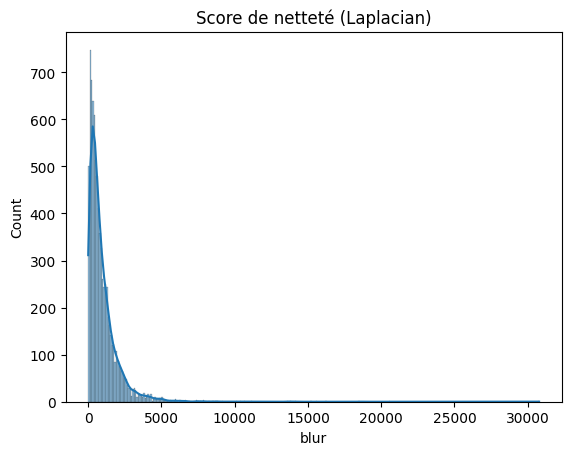

In [35]:
def blur_score(path):
    img = cv2.imread(path)
    if img is None: return 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

df_sample["blur"] = df_sample["image_path"].apply(blur_score)
sns.histplot(df_sample["blur"], kde=True)
plt.title("Score de netteté (Laplacian)")
plt.show()

Image floue sélectionnée : images/image_train/image_1305560451_product_4144946218.jpg


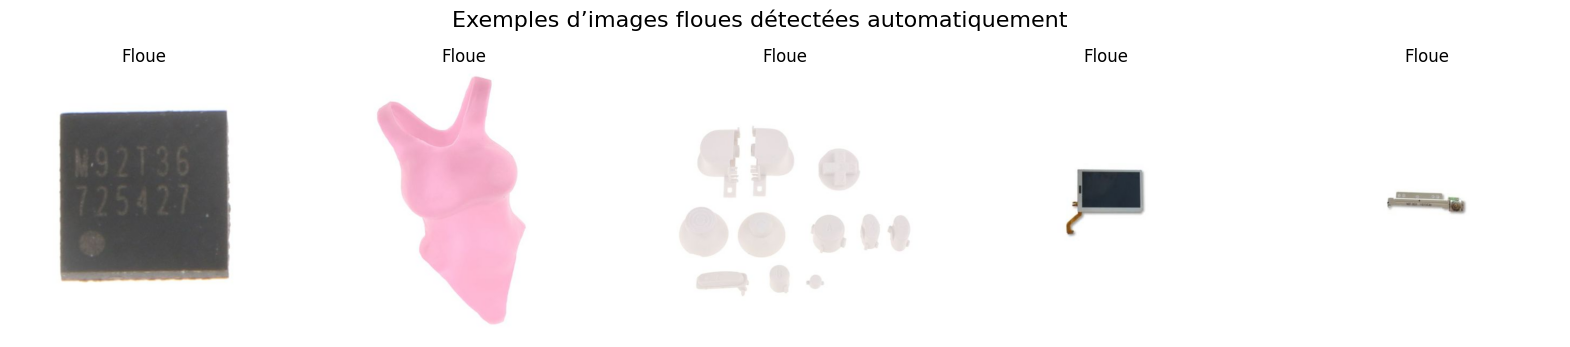

In [36]:
img_flou_path = df_sample[df_sample["blur"] < 20]["image_path"].iloc[0]
print(f"Image floue sélectionnée : {img_flou_path}")



fig, axes = plt.subplots(1, 5, figsize=(20, 4))
flou_paths = df_sample[df_sample["blur"] < 20]["image_path"].head(5)

for ax, path in zip(axes, flou_paths):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title("Floue")
    ax.axis("off")

plt.suptitle("Exemples d’images floues détectées automatiquement", fontsize=16)
plt.show()



/var/folders/f0/q3pz9yqx3x7gnp3hqnj1hqvm0000gn/T/ipykernel_41594/1902792600.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=blur_stats.index.astype(str), y=blur_stats.values, palette="viridis")


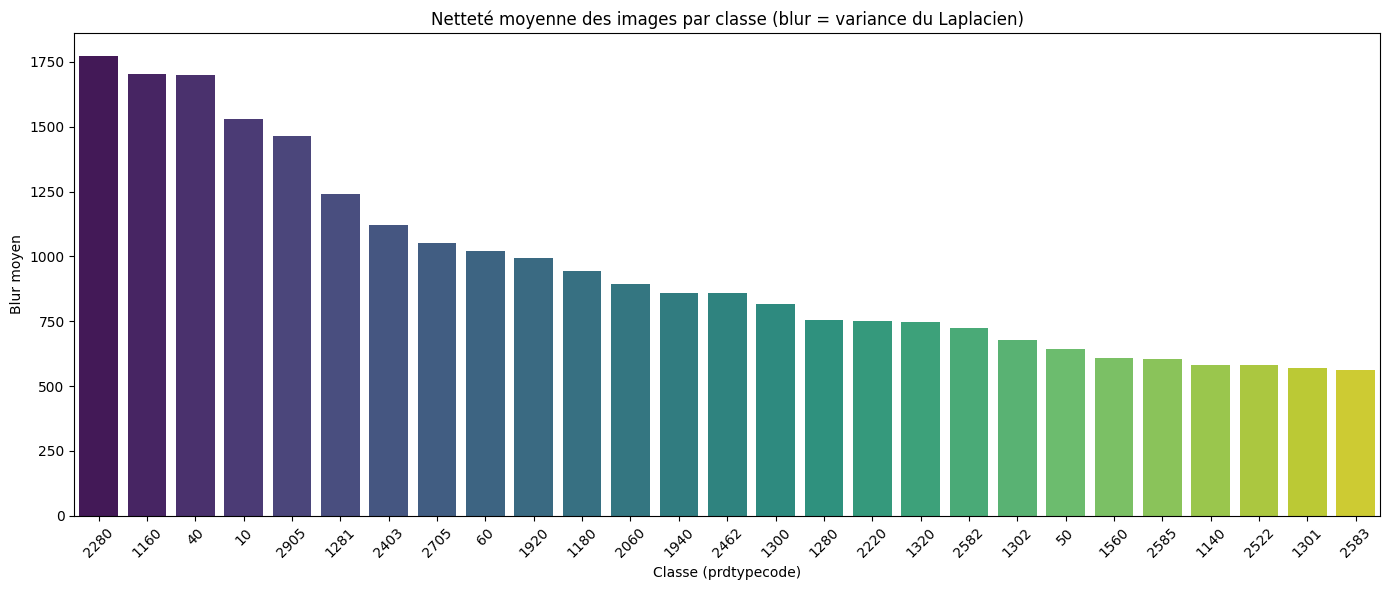

In [37]:
# Moyenne du blur par classe
blur_stats = df_sample.groupby("prdtypecode")["blur"].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(14,6))
sns.barplot(x=blur_stats.index.astype(str), y=blur_stats.values, palette="viridis")
plt.title("Netteté moyenne des images par classe (blur = variance du Laplacien)")
plt.xlabel("Classe (prdtypecode)")
plt.ylabel("Blur moyen")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


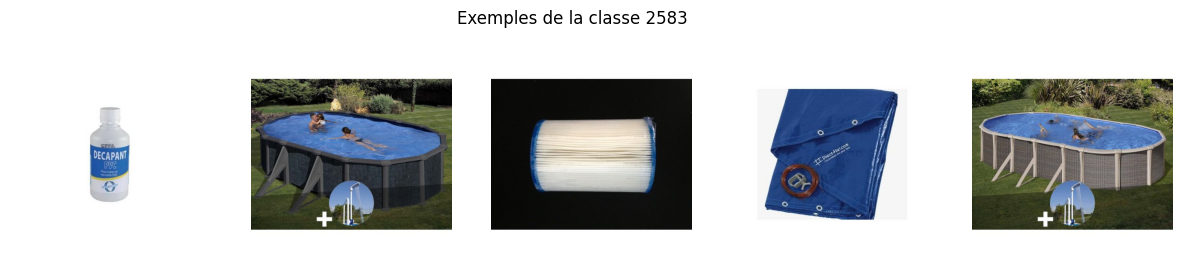

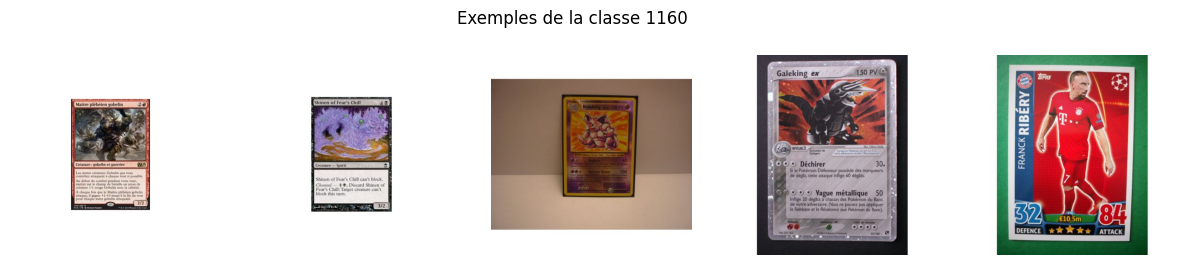

In [38]:

def show_examples(df_sample, label, n=5):
    filtered = df_sample[df_sample["prdtypecode"] == label]
    if len(filtered) < n:
        print(f"Not enough samples for label {label}. Found {len(filtered)} samples.")
        return
    samples = filtered.sample(n=n)
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, path in enumerate(samples["image_path"]):
        img = Image.open(path)
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle(f"Exemples de la classe {label}")
    plt.show()

show_examples(df_sample, label=2583)

show_examples(df_sample, label=1160)


## Pré-traitement des données :

In [39]:

# 📏 Taille cible pour 
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32
EPOCHS_PHASE1 = 5
EPOCHS_PHASE2 = 10



In [40]:
# Étapes :
preprocessor = ImagePreprocessor(img_size=IMG_SIZE)

# 1. Filtrage + nettoyage des images + sauvegarde dans images_cleaned/
df_sample = preprocessor.apply_filtering_and_save(df_sample)

# 2. Chargement des images propres en tableau numpy
X_imgs = preprocessor.load_cleaned_images(df_sample)


100%|██████████| 8092/8092 [00:02<00:00, 2899.17it/s]


In [41]:
# Labels encodés

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["prdtypecode"])
y_cat = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)


#### Train / Test Split :

In [42]:
from sklearn.model_selection import train_test_split

# Filter y_cat to match df_sample
filtered_indices = df_sample.index
y_cat_filtered = y_cat[filtered_indices]

X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_imgs, y_cat_filtered, test_size=0.1, random_state=42)


In [43]:
# generator_builder = ImageGeneratorBuilder(img_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=True)

# train_gen, val_gen = generator_builder.build_generators(df_sample)

## Modélisation : 

#### Baseline : Resnet50 

In [ ]:
clf = CustomClassifier(model_name="resnet50", input_shape=(224, 224, 3),
                       num_classes=len(train_gen.class_indices), two_phase=False)
clf.train(train_gen, val_gen, data_type='generator' , epochs=10)


=== Entraînement standard ===


/Users/toninrvr/Documents/MOSEF venv/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0817 - loss: 3.4087

#### EfficientnetB0 :
(sur un plus petit echantillon car nécessite des images avec 260x260)

In [16]:
# df_sample_mini = df.groupby("prdtypecode").apply(lambda x: x.sample(n=min(len(x), 10), random_state=42)).reset_index(drop=True)

# # Étapes :
# preprocessor = ImagePreprocessor(img_size=(260, 260))

# # 1. Filtrage + nettoyage des images + sauvegarde dans images_cleaned/
# df_sample_mini = preprocessor.apply_filtering_and_save(df_sample_mini)

# # 2. Chargement des images propres en tableau numpy
# X_imgs = preprocessor.load_cleaned_images(df_sample_mini)

# EfficientNetB0 = CustomClassifier(model_name="efficientnetb0", input_shape=(224, 224, 3),
#                                   num_classes=len(train_gen.class_indices), two_phase=False)
# EfficientNetB0.train(train_gen, val_gen, data_type='generator' , epochs=10)

#### ResNet50 en 2 phases : 

In [ ]:
# clf = CustomClassifier(model_name="resnet50", input_shape=(224, 224, 3),
#                        num_classes=len(train_gen.class_indices), two_phase=True)
# clf.train((X_train_img, y_train_img), (X_val_img, y_val_img), data_type='array', phase1_epochs=5, phase2_epochs=5)



=== Phase 1 : gel complet du modèle ===
Epoch 1/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.0655 - loss: 3.4643 - val_accuracy: 0.0938 - val_loss: 3.1669 - learning_rate: 1.0000e-04
Epoch 2/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.1215 - loss: 3.1056 - val_accuracy: 0.0901 - val_loss: 3.1704 - learning_rate: 1.0000e-04
Epoch 3/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 324s 1s/step - accuracy: 0.1356 - loss: 3.0800 - val_accuracy: 0.0914 - val_loss: 3.1638 - learning_rate: 1.0000e-04
Epoch 4/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 332s 1s/step - accuracy: 0.1214 - loss: 3.0895 - val_accuracy: 0.0889 - val_loss: 3.1667 - learning_rate: 1.0000e-04
Epoch 5/5
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1280 - loss: 3.0792
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
228/228 ━━━━━━━━━━━━━━━━━━━━ 337s 1s/step - accuracy: 0.1280 - loss: 3.0792 - val_accuracy: 0.0914 - val_loss: 3.1655 - learning_rate: 1.0000e-04
Restoring model weights from 

26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 893ms/step - accuracy: 0.0227 - loss: 4.3362
🔍 Évaluation sur val_gen — Loss: 4.2996, Accuracy: 0.0259
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
              precision    recall  f1-score   support

          10       0.00      0.00      0.00        30
        1140       0.02      0.03      0.03        30
        1160       0.08      0.03      0.05        30
        1180       0.00      0.00      0.00        30
        1280       0.04      0.03      0.04        30
        1281       0.02      0.03      0.02        30
        1300       0.00      0.00      0.00        30
        1301       0.00      0.00      0.00        30
        1302       0.33      0.07      0.11        30
        1320       0.10      0.10      0.10        30
        1560       0.00      0.00      0.00        30
        1920       0.00      0.00      0.00        30
        1940       0.00      0.00      0.00        30
        2060       0.00      0.00      0.00        30
        2220    

/Users/toninrvr/Documents/MOSEF venv/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/toninrvr/Documents/MOSEF venv/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/toninrvr/Documents/MOSEF venv/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

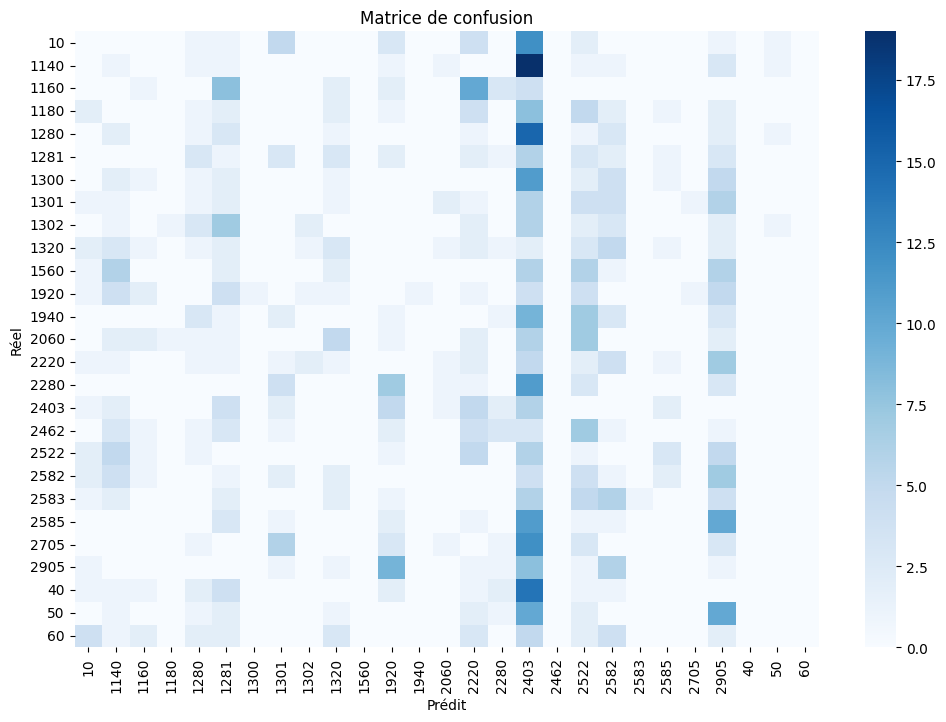

In [ ]:
# === Prédictions sur le set de validation ===
y_pred_val = clf.predict(X_val_img)
y_pred_labels = np.argmax(y_pred_val, axis=1)
y_true_labels = np.argmax(y_val_img, axis=1)

# === F1-score weighted ===
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
print(f"📊 F1-score (pondéré) sur validation : {f1:.4f}")

# === Accuracy simple ===
loss, accuracy = clf.model.evaluate(X_val_img, y_val_img, verbose=0)
print(f"🔍 Accuracy sur validation : {accuracy:.4f} — Loss : {loss:.4f}")

# === Rapport de classification ===
print("\n📄 Rapport de classification :\n")
print(classification_report(y_true_labels, y_pred_labels))


In [ ]:
# === Top-3 Accuracy ===
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

top3 = top_3_accuracy(y_val_img, y_pred_val).numpy().mean()
print(f"🏅 Top-3 Accuracy : {top3:.4f}")

In [ ]:
# === Matrice de confusion ===
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("🧩 Matrice de confusion")
plt.show()



              precision    recall  f1-score   support

          10       0.18      0.29      0.22         7
          40       0.14      0.11      0.12         9
          50       0.44      0.27      0.33        15
          60       0.44      0.78      0.56         9
        1140       0.38      0.42      0.40        12
        1160       0.75      1.00      0.86         9
        1180       0.67      0.20      0.31        10
        1280       0.80      0.40      0.53        10
        1281       0.67      0.15      0.25        13
        1300       0.29      0.44      0.35         9
        1301       0.73      0.62      0.67        13
        1302       0.33      0.12      0.18         8
        1320       0.12      0.08      0.10        13
        1560       0.50      0.29      0.36        14
        1920       0.80      0.86      0.83        14
        1940       0.35      0.78      0.48         9
        2060       0.00      0.00      0.00        17
        2220       0.00    

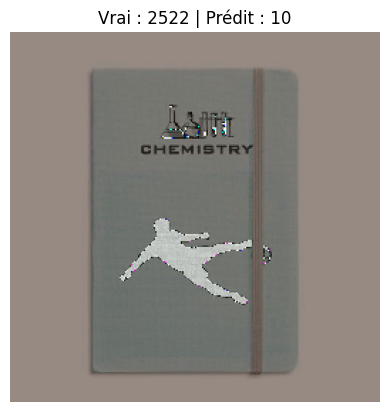

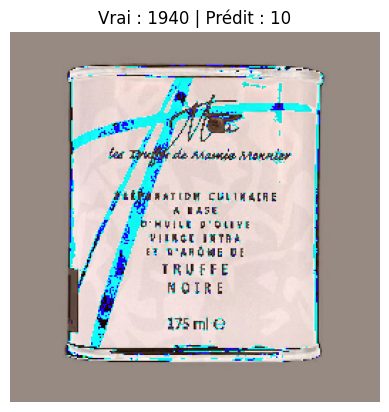

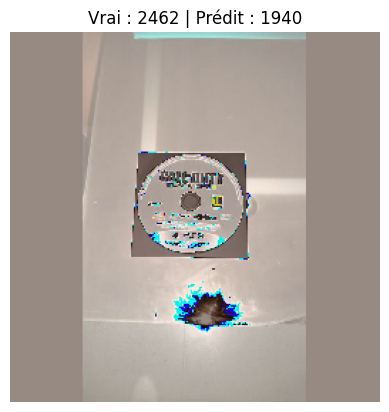

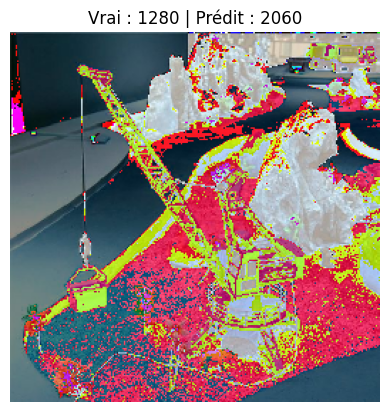

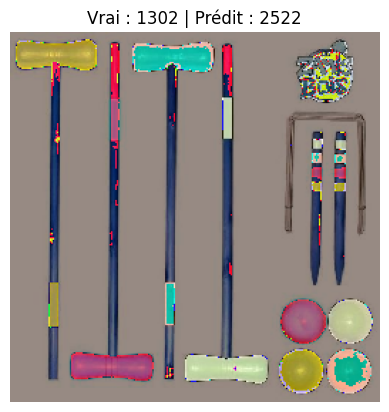

In [ ]:
wrong = np.where(y_true_labels != y_pred_labels)[0]

for i in wrong[:5]:  # 5 erreurs
    plt.imshow(X_val_img[i].astype("uint8"))
    true_label = label_encoder.inverse_transform([y_true_labels[i]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_labels[i]])[0]
    plt.title(f"Vrai : {true_label} | Prédit : {pred_label}")
    plt.axis("off")
    plt.show()


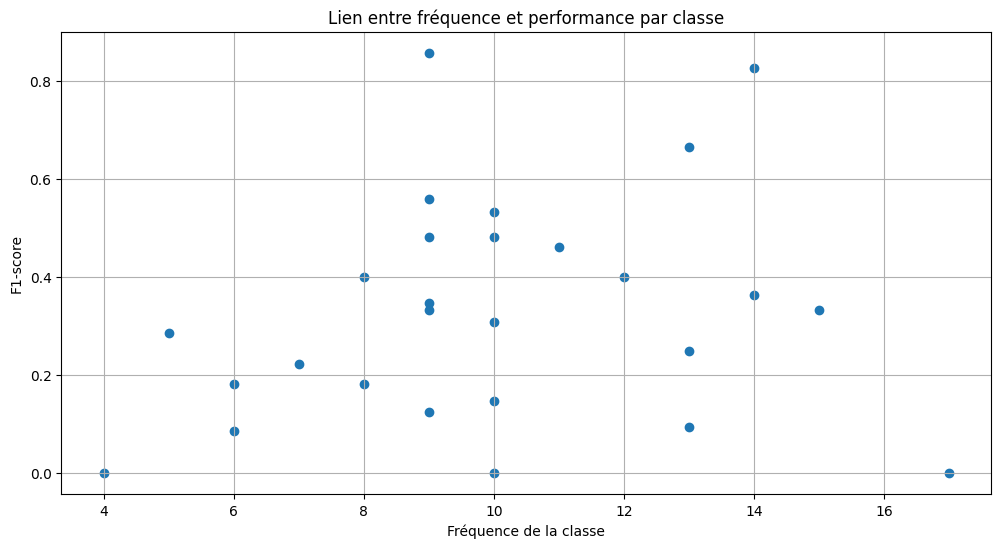

In [ ]:

counts = pd.Series(y_true_labels).value_counts().sort_index()
performance = pd.Series([
    f1_score((y_true_labels == i).astype(int), (y_pred_labels == i).astype(int))
    for i in range(num_classes)
])

plt.figure(figsize=(12, 6))
plt.scatter(counts, performance)
plt.xlabel("Fréquence de la classe")
plt.ylabel("F1-score")
plt.title("Lien entre fréquence et performance par classe")
plt.grid(True)
plt.show()
